Get dataset from official repository


In [ ]:
# Clone the entire repo.
!git clone -l -s https://github.com/karolpiczak/ESC-50.git
!ls

Cloning into 'ESC-50'...
remote: Enumerating objects: 4136, done.
remote: Total 4136 (delta 0), reused 0 (delta 0), pack-reused 4136
Receiving objects: 100% (4136/4136), 878.77 MiB | 28.22 MiB/s, done.
Resolving deltas: 100% (247/247), done.
Checking out files: 100% (2011/2011), done.
drive  ESC-50  sample_data


In [1]:
from pathlib import Path
from scipy.io import wavfile
from IPython.display import Audio
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt 
import librosa
from tqdm import tqdm, tqdm_notebook, notebook
import gc
import time 

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow import keras
from tensorflow.keras.layers import BatchNormalization

library for live plotting of the training accuracy and loss

In [2]:
!pip install livelossplot
from livelossplot import PlotLossesKeras

Read wav files

In [ ]:
ROOT = '/content/ESC-50/audio'

audio_list = []
for audio in Path(ROOT).iterdir():
    try:
        sr, this_sound = wavfile.read(audio)
        audio_list.append(this_sound)
    except:
        print('cannot read ', str(audio))

print(len(audio_list))
audio = (np.array(audio_list))
print(np.shape(audio))

del audio_list

#why is not already normalized
audio = np.float32(audio)/np.max(np.abs(audio))

2000
(2000, 220500)


Read csv file

In [ ]:
colnames = ['filename','fold','target','category','esc10','src_file','take']
csv = pd.read_csv('/content/ESC-50/meta/esc50.csv', header=0)
label_list = csv.target.tolist()
fold_list = csv.fold.tolist()
category_list = csv.category.tolist()
name_list = csv.filename.tolist()

print(label_list)
print(fold_list)

label = np.float32(np.array(label_list))
fold = np.float32(np.array(fold_list))
class_dict = dict(zip(label_list, category_list))

print(class_dict)

[0, 14, 36, 36, 19, 19, 30, 34, 9, 30, 30, 22, 22, 22, 0, 22, 19, 48, 48, 48, 48, 22, 22, 22, 41, 47, 31, 17, 45, 8, 15, 15, 15, 46, 46, 37, 32, 16, 37, 25, 25, 25, 25, 25, 25, 4, 4, 48, 48, 3, 15, 27, 27, 43, 12, 40, 40, 40, 40, 40, 40, 29, 10, 12, 7, 12, 12, 12, 26, 4, 6, 6, 40, 40, 44, 44, 23, 31, 20, 4, 4, 4, 49, 43, 24, 24, 7, 8, 8, 36, 36, 36, 41, 41, 41, 39, 3, 28, 18, 2, 2, 2, 2, 2, 20, 20, 20, 10, 46, 35, 38, 38, 25, 20, 20, 46, 44, 15, 15, 19, 19, 49, 35, 35, 43, 43, 19, 19, 19, 47, 43, 48, 48, 2, 2, 2, 21, 43, 43, 30, 10, 1, 35, 35, 28, 28, 1, 18, 11, 11, 43, 16, 10, 21, 26, 26, 18, 0, 0, 23, 23, 23, 24, 6, 6, 42, 42, 21, 4, 4, 0, 35, 35, 29, 26, 5, 5, 1, 1, 14, 14, 37, 38, 26, 26, 23, 23, 23, 23, 47, 29, 14, 14, 9, 9, 11, 11, 1, 28, 46, 28, 1, 28, 34, 12, 38, 1, 11, 34, 47, 47, 47, 47, 1, 27, 31, 14, 12, 18, 49, 36, 7, 7, 41, 41, 21, 21, 16, 16, 5, 5, 5, 28, 46, 38, 35, 8, 8, 10, 44, 44, 15, 17, 44, 17, 16, 16, 16, 25, 18, 17, 17, 33, 33, 33, 33, 33, 33, 33, 33, 24, 30, 24,

# PREPROCESSING

In [ ]:

def audio_aug2(y, sr=44100, low_ps=-3.5, high_ps=3.5, low_ts=0.8, high_ts=1):
    '''It return a signal with random pitch shift ot time strecth '''

    choice = int(np.random.randint(2))
    if choice == 0:
        step = np.random.uniform(low=low_ps, high=high_ps)
        ya = librosa.effects.pitch_shift(y, sr=sr, n_steps=step)
    elif choice == 1:
        rate = np.random.uniform(low=low_ts, high=high_ts)
        ya = librosa.effects.time_stretch(y, rate)
    return ya


Augment the audio and compute the mel spectrogram.
60 filters for the mel features

FOLDWISE function

In [ ]:
def preprocess_aug_fold(audio, label, fold, aug_rate, n_mel=60, n_t=200, export=True):
    # n_mel = 60 
    # n_t = 200

    #how much augmentation
    # aug_rate = 4
    if aug_rate == 0:
        data_mel = np.zeros((len(label),n_mel, n_t))
        for i in notebook.tqdm(range(len(label))):
            data_mel[i,:,:] = librosa.amplitude_to_db(np.abs(librosa.feature.melspectrogram(np.asfortranarray(audio[i]), n_fft=1024, hop_length=1102, n_mels=n_mel))[:, :200])   
        label_aug = label
    else:
        data_mel = np.zeros((aug_rate*len(label),n_mel, n_t))
        for i in notebook.tqdm(range(len(label))):
            for j in range(aug_rate):        
                data_mel[i*aug_rate+j,:,:] = librosa.amplitude_to_db(np.abs(librosa.feature.melspectrogram(audio_aug2(np.asfortranarray(audio[i])), n_fft=1024, hop_length=1102, n_mels=n_mel))[:, :200])
        label_aug = np.repeat(label, aug_rate, axis=0)
    
    print(np.shape(data_mel),'  ', np.shape(label_aug))

    if export:
        np.save('/content/drive/My Drive/hda_data/data_mel_f'+str(fold)+'_x'+ str(aug_rate)+'.npy', data_mel)
        np.save('/content/drive/My Drive/hda_data/label_aug_f'+str(fold)+'_x'+str(aug_rate)+'.npy', label_aug)
        print('saved ok')

    return data_mel, label_aug

In [ ]:
aug_rate = 1
data_mel_aug = np.zeros((5, 400*aug_rate, 60, 200))
data_mel_val = np.zeros((5, 400, 60, 200))

label_aug = np.zeros((5, 400*aug_rate))
label_val = np.zeros((5, 400))

for i in range(5):
    print('processing fold', i,' validation')
    data_mel_val[i], label_val[i] = preprocess_aug_fold(audio=audio[i*400:(i+1)*400], label=label[i*400:(i+1)*400], fold=i, aug_rate=0)
    print('processing fold ', i, ' training')
    data_mel_aug[i], label_aug[i] = preprocess_aug_fold(audio=audio[i*400:(i+1)*400], label=label[i*400:(i+1)*400], fold=i, aug_rate=aug_rate)
    

    

processing fold 0  validation



(400, 60, 200)    (400,)
saved ok
processing fold  0  training



(400, 60, 200)    (400,)
saved ok
processing fold 1  validation



(400, 60, 200)    (400,)
saved ok
processing fold  1  training



(400, 60, 200)    (400,)
saved ok
processing fold 2  validation



(400, 60, 200)    (400,)
saved ok
processing fold  2  training



(400, 60, 200)    (400,)
saved ok
processing fold 3  validation



(400, 60, 200)    (400,)
saved ok
processing fold  3  training



(400, 60, 200)    (400,)
saved ok
processing fold 4  validation



(400, 60, 200)    (400,)
saved ok
processing fold  4  training



(400, 60, 200)    (400,)
saved ok


In [ ]:

print(np.shape(data_mel_aug))
print(np.shape(data_mel_val))
print(np.shape(label_aug))
print(np.shape(label_val))



(5, 1600, 60, 200)
(5, 400, 60, 200)
(5, 1600)
(5, 400)


Release some memory

In [ ]:
# del audio
del data_mel
gc.collect()

or load pre augmented data

In [ ]:
# np.save('/content/drive/My Drive/hda_data/data_mel5.npy', data_mel)
# np.save('/content/drive/My Drive/hda_data/label_aug5.npy', label_aug)

Load every fold, augmented and not  
Careful with RAM usage



In [ ]:
aug_rate = 4

data_mel_aug = np.zeros((5, 400*aug_rate, 60, 200))
data_mel_val = np.zeros((5, 400, 60, 200))

label_aug = np.zeros((5, 400*aug_rate))
label_val = np.zeros((5, 400))

# for i in range(5):
#     data_mel_aug[i*400:(i+1)*400] = np.load('/content/drive/My Drive/hda_data/data_mel_f'+str(i)+'_x'+ str(aug_rate)+'.npy')
#     data_mel_val[i*400:(i+1)*400] = np.load('/content/drive/My Drive/hda_data/data_mel_f'+str(i)+'_x0.npy')
#     label_aug[i*400:(i+1)*400] = np.load('/content/drive/My Drive/hda_data/label_aug_f'+str(i)+'_x' + str(aug_rate)+'.npy')
#     label_val[i*400:(i+1)*400] = np.load('/content/drive/My Drive/hda_data/label_aug_f'+str(i)+'_x0.npy')

for i in notebook.tqdm(range(5)):
    data_mel_aug[i] = np.load('/content/drive/My Drive/hda_data/data_mel_f'+str(i)+'_x'+ str(aug_rate)+'.npy')
    data_mel_val[i] = np.load('/content/drive/My Drive/hda_data/data_mel_f'+str(i)+'_x0.npy')
    label_aug[i] = np.load('/content/drive/My Drive/hda_data/label_aug_f'+str(i)+'_x' + str(aug_rate)+'.npy')
    label_val[i] = np.load('/content/drive/My Drive/hda_data/label_aug_f'+str(i)+'_x0.npy')


Slicing audio:
for every 5 seconds audio make 32 slices that are overlapped by 80% of their length. 
At the end we have short mel spectrograms with size 60 x 40

In [ ]:
def spectrogram_slicer(data_mel, label_aug):

    #it also normalizes and adapts the dimesion of the dataset
    def normalize01(x):
        y = (x - np.min(x)) / (np.max(x) - np.min(x))
        return y

    data_mel = normalize01(data_mel)

    n_mel = 60

    good_slice = 0
    bad_slice = 0
    label_slice = np.zeros((32*label_aug.shape[0], 1))
    # print(np.shape(label_slice))
    slice_len = 40
    slice_mel = np.zeros((32*len(label_aug), n_mel, slice_len))
    # print(np.shape(slice_mel))

    for i in notebook.tqdm(range(len(label_aug))):
        for j in range(32):
            
            this_slice = data_mel[i,:,j*5:j*5+40]
            floor = np.min(this_slice)
            if np.max(this_slice)==np.min(this_slice):   
                bad_slice +=1
            else:           
                slice_mel[good_slice] = data_mel[i,:,j*5:j*5+40] 
                label_slice[good_slice] = label_aug[i]
                good_slice +=1
    slice_mel = slice_mel[:good_slice]
    label_slice = label_slice[:good_slice]

    slice_mel = np.expand_dims(slice_mel, -1)

    print('slices deleted: ',bad_slice)

    return slice_mel, label_slice


In [ ]:
# slice_mel_aug = np.zeros((np.shape(data_mel_aug)[0], 32*np.shape(data_mel_aug)[1], np.shape(data_mel_aug)[2], 40))
# label_slice_aug = np.zeros((np.shape(label_aug)[0], 32*np.shape(label_aug)[1]))

# slice_mel_val = np.zeros((np.shape(data_mel_val)[0], 32*np.shape(data_mel_val)[1], np.shape(data_mel_val)[2], 40))
# label_slice_val = np.zeros((np.shape(label_val)[0], 32*np.shape(label_val)[1]))

#need to make lists because they vary in the lenght since we delete silent slices
slice_mel_aug = []
label_slice_aug = []
slice_mel_val = []
label_slice_val = []

for i in range(5):
    this_slice_aug, this_label_aug = spectrogram_slicer(data_mel_aug[i], label_aug[i])
    print(np.shape(this_slice_aug), ' ', np.shape(this_label_aug))
    slice_mel_aug.append(this_slice_aug)
    del this_slice_aug
    label_slice_aug.append(this_label_aug)
    del this_label_aug
    this_slice_val, this_label_val = spectrogram_slicer(data_mel_val[i], label_val[i])
    print(np.shape(this_slice_val), ' ', np.shape(this_label_val))
    slice_mel_val.append(this_slice_val)
    del this_slice_val
    label_slice_val.append(this_label_val)
    del this_label_val
    gc.collect


slices deleted:  4280
(46920, 60, 40, 1)   (46920, 1)



slices deleted:  1136
(11664, 60, 40, 1)   (11664, 1)



slices deleted:  4662
(46538, 60, 40, 1)   (46538, 1)



slices deleted:  1217
(11583, 60, 40, 1)   (11583, 1)



slices deleted:  4626
(46574, 60, 40, 1)   (46574, 1)



slices deleted:  1194
(11606, 60, 40, 1)   (11606, 1)



slices deleted:  4334
(46866, 60, 40, 1)   (46866, 1)



slices deleted:  1136
(11664, 60, 40, 1)   (11664, 1)



slices deleted:  5554
(45646, 60, 40, 1)   (45646, 1)



slices deleted:  1463
(11337, 60, 40, 1)   (11337, 1)


In [ ]:
del data_mel_aug, data_mel_val
gc.collect()

322

In [ ]:
print(bad_slice)
print(np.shape(slice_mel))

print(np.min(slice_mel))

NameError: ignored

# Classifier from mel features

make training and validation sets

In [2]:

def preprocesser_fold(fold, aug_rate):

    def spectrogram_slicer(data_mel, label_aug):

        #it also normalizes and adapts the dimension of the dataset
        def normalize01(x):
            y = (x - np.min(x)) / (np.max(x) - np.min(x))
            return y

        data_mel = normalize01(data_mel)

        n_mel = 60

        good_slice = 0
        bad_slice = 0
        label_slice = np.zeros((32*label_aug.shape[0], 1))
        # print(np.shape(label_slice))
        slice_len = 40
        slice_mel = np.zeros((32*len(label_aug), n_mel, slice_len))
        # print(np.shape(slice_mel))

        for i in notebook.tqdm(range(len(label_aug))):
            for j in range(32):
                
                this_slice = data_mel[i,:,j*5:j*5+40]
                floor = np.min(this_slice)
                if np.max(this_slice)==np.min(this_slice):   
                    bad_slice +=1
                else:           
                    slice_mel[good_slice] = data_mel[i,:,j*5:j*5+40] 
                    label_slice[good_slice] = label_aug[i]
                    good_slice +=1
        slice_mel = slice_mel[:good_slice]
        label_slice = label_slice[:good_slice]
        slice_mel = np.expand_dims(slice_mel, -1)
        print('slices deleted: ',bad_slice)
        return slice_mel, label_slice

    data_mel_aug = np.zeros((4, 400*aug_rate, 60, 200))
    label_aug = np.zeros((4, 400*aug_rate))

    slice_mel_aug = []
    label_slice_aug = []

    c = 0
    for i in notebook.tqdm(range(5)):
        if i == fold:
            data_mel_val = np.load('/content/drive/My Drive/hda_data/data_mel_f'+str(i)+'_x0.npy')
            label_val = np.load('/content/drive/My Drive/hda_data/label_aug_f'+str(i)+'_x0.npy')

            slice_mel_val, label_slice_val = spectrogram_slicer(data_mel_val, label_val)
            
        else:
            # c += 1
            # data_mel_aug[c] = np.load('/content/drive/My Drive/hda_data/data_mel_f'+str(i)+'_x'+ str(aug_rate)+'.npy') 
            # label_aug[c] = np.load('/content/drive/My Drive/hda_data/label_aug_f'+str(i),'_x'+str(aug_rate)+'.npy')
            # this_slice_aug, this_label_aug = spectrogram_slicer(data_mel_aug[c], label_aug[c])
            
            this_slice_aug, this_label_aug = spectrogram_slicer(np.load('/content/drive/My Drive/hda_data/data_mel_f'+str(i)+'_x'+ str(aug_rate)+'.npy'),
                                                                np.load('/content/drive/My Drive/hda_data/label_aug_f'+str(i)+'_x'+str(aug_rate)+'.npy'))
            slice_mel_aug.append(this_slice_aug)
            del this_slice_aug
            label_slice_aug.append(this_label_aug)
            del this_label_aug
            gc.collect
    

    slice_mel_aug = np.vstack(slice_mel_aug)
    label_slice_aug = np.vstack(label_slice_aug)

    return slice_mel_aug, slice_mel_val, label_slice_aug, label_slice_val



In [26]:
def simpler_preprocesser_fold(fold, aug_rate):



    def normalizer(data_mel, label_aug):

        #it also normalizes and adapts the dimension of the dataset
        def normalize01(x):
            y = (x - np.min(x)) / (np.max(x) - np.min(x))
            
            return y

        data_mel = normalize01(data_mel)
        data_mel = np.expand_dims(data_mel,-1)
        
        label_slice = np.zeros((label_aug.shape[0], 1))
        for i in range(label_aug.shape[0]):
            label_slice[i] = label_aug[i]
        return data_mel, label_slice

    data_mel_aug = np.zeros((4, 400*aug_rate, 60, 200))
    label_aug = np.zeros((4, 400*aug_rate))

    slice_mel_aug = []
    label_slice_aug = []

    c = 0
    for i in notebook.tqdm(range(5)):
        if i == fold:
            data_mel_val = np.load('/content/drive/My Drive/hda_data/data_mel_f'+str(i)+'_x0.npy')
            label_val = np.load('/content/drive/My Drive/hda_data/label_aug_f'+str(i)+'_x0.npy')

            slice_mel_val, label_slice_val = normalizer(data_mel_val, label_val)
            
        else:
            # c += 1
            # data_mel_aug[c] = np.load('/content/drive/My Drive/hda_data/data_mel_f'+str(i)+'_x'+ str(aug_rate)+'.npy') 
            # label_aug[c] = np.load('/content/drive/My Drive/hda_data/label_aug_f'+str(i),'_x'+str(aug_rate)+'.npy')
            # this_slice_aug, this_label_aug = spectrogram_slicer(data_mel_aug[c], label_aug[c])
            
            this_slice_aug, this_label_aug = normalizer(np.load('/content/drive/My Drive/hda_data/data_mel_f'+str(i)+'_x'+ str(aug_rate)+'.npy'),
                                                                np.load('/content/drive/My Drive/hda_data/label_aug_f'+str(i)+'_x'+str(aug_rate)+'.npy'))
            slice_mel_aug.append(this_slice_aug)
            del this_slice_aug
            label_slice_aug.append(this_label_aug)
            print(np.shape(this_label_aug))
            del this_label_aug
            gc.collect
    

    slice_mel_aug = np.vstack(slice_mel_aug)
    label_slice_aug = np.vstack(label_slice_aug)

    return slice_mel_aug, slice_mel_val, label_slice_aug, label_slice_val


In [3]:
gc.collect()
X_train, X_val, y_train, y_val = preprocesser_fold(4, 4)
print(np.shape(X_train), '  ', np.shape(y_train))
print(np.shape(X_val), '  ', np.shape(y_val))


slices deleted:  4280



slices deleted:  4662



slices deleted:  4626



slices deleted:  4334



slices deleted:  1254

(186898, 60, 40, 1)    (186898, 1)
(11546, 60, 40, 1)    (11546, 1)


In [27]:
# prova senza slice
gc.collect()
X_train, X_val, y_train, y_val = simpler_preprocesser_fold(4, 0)
print(np.shape(X_train), '  ', np.shape(y_train))
print(np.shape(X_val), '  ', np.shape(y_val))

(400, 1)
(400, 1)
(400, 1)
(400, 1)

(1600, 60, 200, 1)    (1600, 1)
(400, 60, 200, 1)    (400, 1)


In [24]:
print(np.shape(y_train))
y_train = np.hstack
print(np.shape(y_train))

(4, 400)
()


In [18]:
print(y_train)

[[ 0. 14. 36. ... 49. 49. 31.]
 [43.  1. 10. ...  7.  7.  7.]
 [18. 27. 27. ... 46. 18. 46.]
 [49. 49. 49. ...  4.  4.  4.]]


In [ ]:
plt.figure()
plt.plot(y_val)
plt.figure()
plt.plot(y_train)

[19.]


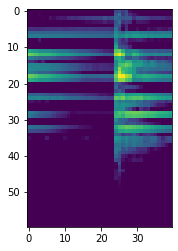

In [ ]:
from matplotlib import pyplot as plt
plt.imshow(X_val[120].reshape(60,40))
print(y_val[120])
# print(y_val[0:100])

In [28]:
def define_mel_classifier():
    input = keras.Input(shape=(60,200,1))
    x = layers.Conv2D(32,   kernel_size=(3,3), strides=(2,2), padding='same', activation='relu')(input)
    x = layers.Dropout(0.2)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(64, kernel_size=(3,3), strides=(2,2), padding='same', activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(128, kernel_size=(3,3), strides=(2,2), padding='same', activation='relu')(x)  #dont reduce dimension
    x = layers.Dropout(0.3)(x)
    x = layers.BatchNormalization()(x)   
    x = layers.Flatten()(x)
    x = layers.Dense(100, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    x = layers.BatchNormalization()(x)   
    # x = layers.Dense(100, activation='relu')(x)
    # x = layers.Dropout(0.3)(x)
    # x = layers.BatchNormalization()(x)
    x = layers.Dense(50, activation='softmax')(x)
    mel_classifier = keras.Model(input, x, name='mel_classifier')
    return mel_classifier


# def define_mel_classifier():
#     input = keras.Input(shape=(60,40,1))
#     x = layers.Conv2D(64,   kernel_size=(3,1), strides=(2,2), padding='same')(input)
#     x = layers.Conv2D(64,   kernel_size=(1,3), strides=(2,2), padding='same')(x)
#     x = layers.ReLU()(x)
#     # x = layers.Dropout(0.1)(x)
#     x = layers.BatchNormalization()(x)
#     x = layers.Conv2D(64, kernel_size=(3,1), strides=(1,1), padding='same')(x)
#     x = layers.Conv2D(64, kernel_size=(1,3), strides=(1,1), padding='same')(x)
#     x = layers.ReLU()(x)
#     # x = layers.Dropout(0.12)(x)
#     x = layers.BatchNormalization()(x)
#     x = layers.Conv2D(128, kernel_size=(3,1), strides=(1,1), padding='same')(x) 
#     x = layers.Conv2D(128, kernel_size=(1,3), strides=(1,1), padding='same')(x) 
#     x = layers.Dropout(0.12)(x)
#     x = layers.BatchNormalization()(x)   
#     x = layers.Flatten()(x)
#     x = layers.Dense(100, activation='relu')(x)
#     x = layers.Dropout(0.1)(x)
#     x = layers.BatchNormalization()(x)   
#     x = layers.Dense(100, activation='relu')(x)
#     x = layers.Dropout(0.1)(x)
#     x = layers.BatchNormalization()(x)
#     x = layers.Dense(50, activation='softmax')(x)
#     mel_classifier = keras.Model(input, x, name='mel_classifier')
#     return mel_classifier

# #with separable kernel
# def define_mel_classifier():
#     input = keras.Input(shape=(60,40,1))
#     x = layers.Conv2D(8,   kernel_size=(3,1), strides=(1,1), padding='same')(input)
#     x = layers.Conv2D(8,   kernel_size=(1,3), strides=(1,1), padding='same')(x)
#     x = layers.ReLU()(x)
#     x = layers.MaxPool2D()(x)
#     x = layers.Dropout(0.4)(x)
#     x = layers.BatchNormalization()(x)
#     x = layers.Conv2D(8, kernel_size=(3,1), strides=(1,1), padding='same')(x)
#     x = layers.Conv2D(8, kernel_size=(1,3), strides=(1,1), padding='same')(x)
#     x = layers.ReLU()(x)
#     x = layers.MaxPool2D()(x)
#     x = layers.Dropout(0.4)(x)
#     x = layers.BatchNormalization()(x)
#     x = layers.Conv2D(8, kernel_size=(3,1), strides=(1,1), padding='same')(x) 
#     x = layers.Conv2D(8, kernel_size=(1,3), strides=(1,1), padding='same')(x) 
#     x = layers.Dropout(0.4)(x)
#     x = layers.BatchNormalization()(x)   
#     x = layers.Flatten()(x)
#     # x = layers.Dense(100, activation='relu')(x)
#     # x = layers.Dropout(0.4)(x)
#     # x = layers.BatchNormalization()(x)   
#     # x = layers.Dense(100, activation='relu')(x)
#     # x = layers.Dropout(0.4)(x)
#     # x = layers.BatchNormalization()(x)
#     x = layers.Dense(50, activation='softmax')(x)
#     mel_classifier = keras.Model(input, x, name='mel_classifier')
#     return mel_classifier

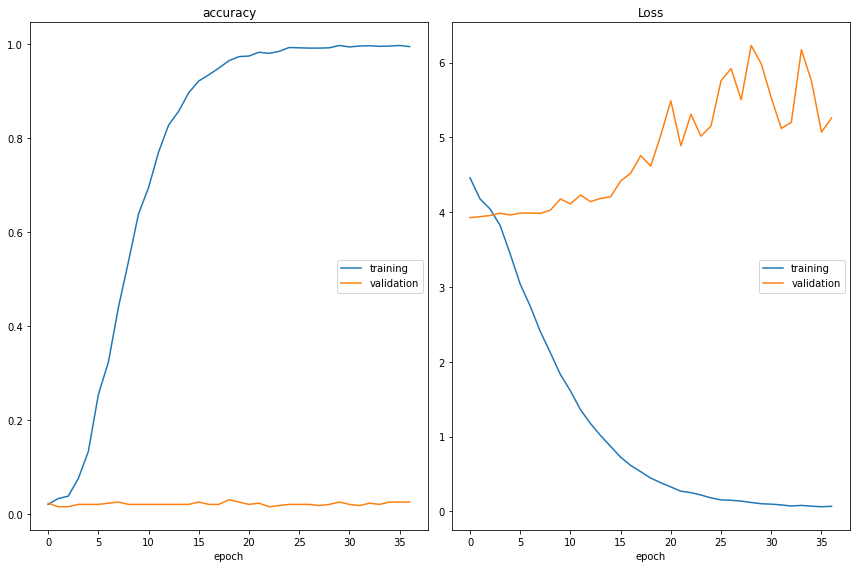

accuracy
	training         	 (min:    0.020, max:    0.998, cur:    0.995)
	validation       	 (min:    0.015, max:    0.030, cur:    0.025)
Loss
	training         	 (min:    0.063, max:    4.460, cur:    0.069)
	validation       	 (min:    3.928, max:    6.230, cur:    5.260)
13/13 [==============================] - 1s 100ms/step - loss: 0.0687 - accuracy: 0.9950 - val_loss: 5.2599 - val_accuracy: 0.0250
Epoch 38/130
 6/13 [============>.................] - ETA: 0s - loss: 0.0514 - accuracy: 0.9948

KeyboardInterrupt: ignored

In [29]:
gc.collect()

batch_size = 128
epochs = 130

mel_classifier = define_mel_classifier()
mel_classifier.compile(optimizer=keras.optimizers.RMSprop(), loss = keras.losses.sparse_categorical_crossentropy, metrics=['accuracy'])
mel_classifier.summary()

history = mel_classifier.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, callbacks=[PlotLossesKeras()], validation_data=(X_val
, y_val))

In [ ]:
mel_classifier.summary()

with kernel 5,1

In [ ]:
#with separable kernel (5,1)
def define_mel_classifier():
    input = keras.Input(shape=(60,40,1))
    x = layers.Conv2D(64,   kernel_size=(5,1), strides=(1,1), padding='same')(input)
    x = layers.Conv2D(64,   kernel_size=(1,5), strides=(1,1), padding='same')(x)
    x = layers.ReLU()(x)
    x = layers.MaxPool2D()(x)
    # x = layers.Dropout(0.1)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(64, kernel_size=(5,1), strides=(1,1), padding='same')(x)
    x = layers.Conv2D(64, kernel_size=(1,5), strides=(1,1), padding='same')(x)
    x = layers.ReLU()(x)
    x = layers.MaxPool2D()(x)
    # x = layers.Dropout(0.12)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(128, kernel_size=(5,1), strides=(1,1), padding='same')(x) 
    x = layers.Conv2D(128, kernel_size=(1,5), strides=(1,1), padding='same')(x) 
    # x = layers.Dropout(0.12)(x)
    x = layers.BatchNormalization()(x)   
    x = layers.Flatten()(x)
    x = layers.Dense(100, activation='relu')(x)
    x = layers.Dropout(0.1)(x)
    x = layers.BatchNormalization()(x)   
    x = layers.Dense(100, activation='relu')(x)
    x = layers.Dropout(0.1)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dense(50, activation='softmax')(x)
    mel_classifier = keras.Model(input, x, name='mel_classifier')
    return mel_classifier

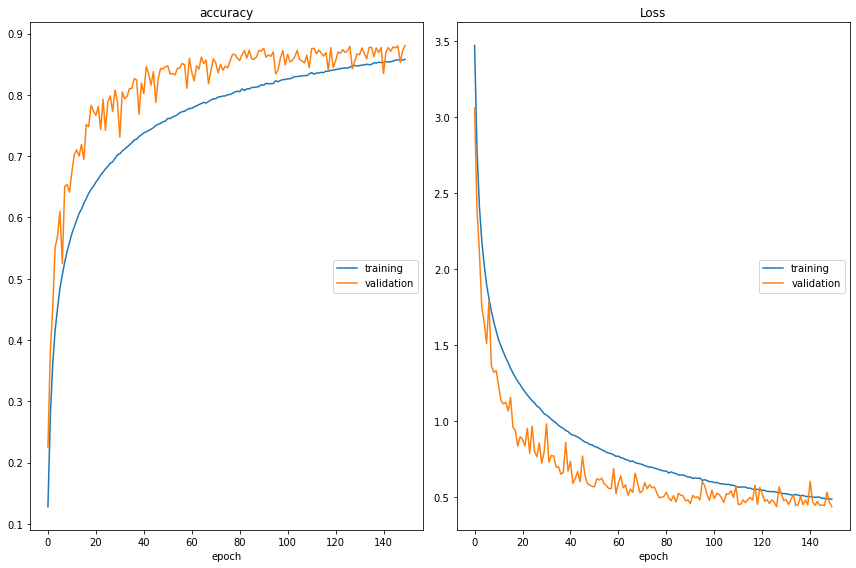

accuracy
	training         	 (min:    0.128, max:    0.858, cur:    0.858)
	validation       	 (min:    0.225, max:    0.881, cur:    0.881)
Loss
	training         	 (min:    0.485, max:    3.473, cur:    0.485)
	validation       	 (min:    0.435, max:    3.062, cur:    0.435)
4824.758947849274


In [ ]:
gc.collect()

start_time = time.time()

batch_size = 128
epochs = 150

mel_classifier = define_mel_classifier()
mel_classifier.compile(optimizer=keras.optimizers.RMSprop(), loss = keras.losses.sparse_categorical_crossentropy, metrics=['accuracy'])
mel_classifier.summary()

history = mel_classifier.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, verbose=0, callbacks=[PlotLossesKeras()], validation_data=(X_val
, y_val))

elapsed_time = time.time() - start_time
print(elapsed_time/60)

let's try 7,1

In [ ]:
#with separable kernel (7,1)
def define_mel_classifier():
    input = keras.Input(shape=(60,40,1))
    x = layers.Conv2D(64,   kernel_size=(7,1), strides=(1,1), padding='same')(input)
    x = layers.Conv2D(64,   kernel_size=(1,7), strides=(1,1), padding='same')(x)
    x = layers.ReLU()(x)
    x = layers.MaxPool2D()(x)
    # x = layers.Dropout(0.1)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(64, kernel_size=(7,1), strides=(1,1), padding='same')(x)
    x = layers.Conv2D(64, kernel_size=(1,7), strides=(1,1), padding='same')(x)
    x = layers.ReLU()(x)
    x = layers.MaxPool2D()(x)
    # x = layers.Dropout(0.12)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(128, kernel_size=(7,1), strides=(1,1), padding='same')(x) 
    x = layers.Conv2D(128, kernel_size=(1,7), strides=(1,1), padding='same')(x) 
    # x = layers.Dropout(0.12)(x)
    x = layers.BatchNormalization()(x)   
    x = layers.Flatten()(x)
    x = layers.Dense(100, activation='relu')(x)
    x = layers.Dropout(0.05)(x)
    x = layers.BatchNormalization()(x)   
    x = layers.Dense(100, activation='relu')(x)
    x = layers.Dropout(0.05)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dense(50, activation='softmax')(x)
    mel_classifier = keras.Model(input, x, name='mel_classifier')
    return mel_classifier

In [ ]:
del slice_mel_aug, slice_mel_val, label_slice_aug, label_slice_val
gc.collect()

152

In [16]:


print(np.shape(X_train), '  ', np.shape(y_train))
print(np.shape(X_val), '  ', np.shape(y_val))

(1600, 60, 200, 1)    (4, 400)
(400, 60, 200, 1)    (400,)


In [ ]:
# # test with fold 0
# X_train = slice_mel_aug[1:]
# y_train = label_slice_aug[1:]
# X_val = slice_mel_val[0]
# y_val = label_slice_val[0]
gc.collect()

start_time = time.time()

batch_size = 128
epochs = 150

mel_classifier = define_mel_classifier()
mel_classifier.compile(optimizer=keras.optimizers.RMSprop(), loss = keras.losses.sparse_categorical_crossentropy, metrics=['accuracy'])
mel_classifier.summary()

history = mel_classifier.fit(X_train,
                             y_train, 
                             batch_size=batch_size, 
                             epochs=epochs, verbose=1, 
                            #  callbacks=[PlotLossesKeras()], 
                             validation_data=(X_val, y_val))

elapsed_time = time.time() - start_time
print(elapsed_time/60)

Model: "mel_classifier"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 60, 40, 1)]       0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 60, 40, 64)        512       
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 60, 40, 64)        28736     
_________________________________________________________________
re_lu_4 (ReLU)               (None, 60, 40, 64)        0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 30, 20, 64)        0         
_________________________________________________________________
batch_normalization_10 (Batc (None, 30, 20, 64)        256       
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 30, 20, 64)     

KeyboardInterrupt: ignored

----------------------------------------------------------------

# VAE again

In [5]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow import keras
from tensorflow.keras.layers import BatchNormalization
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [6]:
def define_encoder(latent_dim):
    encoder_inputs = keras.Input(shape=(60, 40, 1))
    x = layers.Conv2D(64, (3,3), strides=(2,2), padding="same", kernel_regularizer='l2')(encoder_inputs)
    x = layers.LeakyReLU()(x)
    x = layers.Dropout(0.2)(x)
    x = BatchNormalization()(x)
    x = layers.Conv2D(128, (3,3), strides=(2,2), padding="same", kernel_regularizer='l2')(x)
    x = layers.LeakyReLU()(x)
    x = layers.Dropout(0.2)(x)
    x = BatchNormalization()(x)
    x = layers.Conv2D(128, (3,3), strides=(1,1), padding='same')(x)
    x = layers.LeakyReLU()(x)
    x = layers.Dropout(0.2)(x)
    x = BatchNormalization()(x)
    x = layers.Flatten()(x)
    x = layers.Dense(128, activation="sigmoid")(x)
    z_mean = layers.Dense(latent_dim, name="z_mean")(x)
    z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
    z = Sampling()([z_mean, z_log_var])
    encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
    return encoder

def define_decoder(latent_dim):
    latent_inputs = keras.Input(shape=(latent_dim,))
    x = layers.Dense(15 * 10 * 64)(latent_inputs)
    x = layers.LeakyReLU()(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Reshape((15, 10, 64))(x)
    x = layers.Conv2DTranspose(128, (3,3), strides=2, padding="same", kernel_regularizer="l2")(x)
    x = layers.LeakyReLU()(x)
    x = layers.Dropout(0.2)(x)
    x = BatchNormalization()(x)
    x = layers.Conv2D(128, (3,3), strides=(1,1), padding='same')(x)
    x = layers.LeakyReLU()(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Conv2DTranspose(64, (3,3), strides=2, padding="same", kernel_regularizer="l2")(x)
    x = layers.LeakyReLU()(x)
    x = layers.Dropout(0.2)(x)
    x = BatchNormalization()(x)
    decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
    decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
    return decoder


In [7]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = encoder(data)
            reconstruction = decoder(z)
            reconstruction_loss = tf.reduce_mean(
                keras.losses.binary_crossentropy(data, reconstruction)
            )
            reconstruction_loss *= 40 * 60
            kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
            kl_loss = tf.reduce_mean(kl_loss)
            kl_loss *= -0.5
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        return {
            "loss_debug": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }

In [8]:
encoder = keras.models.load_model('/content/drive/My Drive/hda_data/encoder_x5_1.h5', custom_objects={'Sampling': Sampling})

# Classifier from latent space

In [ ]:
# from sklearn.model_selection import KFold
# ci ripenso a fare il k fold

#sarebbe da fare il validation sulle robe senza augmentation e poi anche il pooling del dataset

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(slice_mel, label_slice, test_size=0.2, random_state=111 )

print(np.shape(X_train), '  ', np.shape(X_val))

(139559, 60, 40, 1)    (34890, 60, 40, 1)


In [ ]:
del slice_mel
gc.collect()

1439

In [9]:
def normalize01(x):
    y = (x - np.min(x)) / (np.max(x) - np.min(x))
    return y

X_train_enc = encoder.predict(X_train)[2]
X_val_enc = encoder.predict(X_val)[2]

X_train_enc = normalize01(X_train_enc)
X_val_enc = normalize01(X_val_enc)

print(np.max(X_train_enc), '  ', np.min(X_val_enc))
# X_train_enc = np.expand_dims(X_train_enc, -1)
# X_val_enc = np.expand_dims(X_val_enc, -1)
print(np.shape(X_train_enc), '  ', np.shape(X_val_enc))


1.0    0.0
(186898, 200)    (11546, 200)


defin classifier

In [10]:
print(np.shape(y_train))
print(y_train)
print(np.max(y_train))

(186898, 1)
[[0.]
 [0.]
 [0.]
 ...
 [4.]
 [4.]
 [4.]]
49.0


In [11]:
def define_classifier(latent_dim):
    input = keras.Input(shape=(latent_dim))
    x = layers.Dense(100, activation='relu')(input)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.1)(x)
    x = layers.Dense(100, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.1)(x)
    x = layers.Dense(100, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.1)(x)
    # x = layers.Dense(100, activation='relu')(x)
    # x = layers.BatchNormalization()(x)
    # x = layers.Dropout(0.1)(x)
    x = layers.Dense(100, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.1)(x)
    x = layers.Dense(50, activation='softmax')(x)
    classifier = keras.Model(input, x, name='classifier')
    return classifier

In [12]:
!pip install livelossplot
from livelossplot import PlotLossesKeras

In [13]:
latent_dim = 200

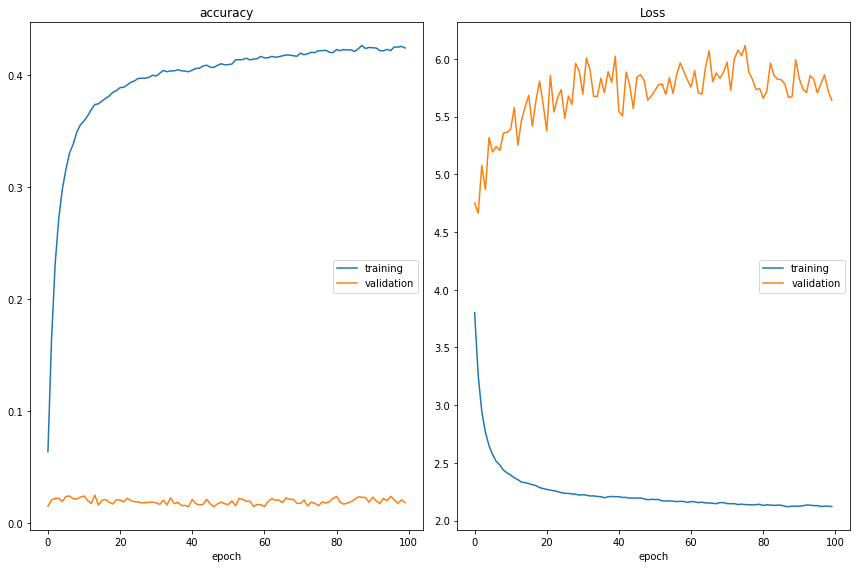

accuracy
	training         	 (min:    0.064, max:    0.427, cur:    0.424)
	validation       	 (min:    0.015, max:    0.025, cur:    0.018)
Loss
	training         	 (min:    2.120, max:    3.802, cur:    2.122)
	validation       	 (min:    4.663, max:    6.116, cur:    5.641)


In [14]:


batch_size = 128
epochs = 100

classifier = define_classifier(latent_dim)
classifier.compile(optimizer=keras.optimizers.RMSprop(), loss = keras.losses.sparse_categorical_crossentropy, metrics=['accuracy'])
classifier.summary()

history = classifier.fit(X_train_enc, y_train, batch_size=batch_size, epochs=epochs, verbose=0, callbacks=[PlotLossesKeras()], validation_data=(X_val_enc, y_val))